In [70]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
from skimage import img_as_int
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching as ast
from imp import reload
from alpenglow.stitching import stitch, find_shift, apply_shift

In [71]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
from skimage.external.tifffile import imread
import skimage.external.tifffile as tif
import skimage
import dask.array as da
from dask import delayed
import glob as globby

In [72]:
import configparser
import os.path as op
import cottoncandy as cc
from io import BytesIO
import tempfile

In [73]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('alpenglowoptics')
ll = list(bucket.objects.all())

In [74]:
file_list = ['/nhsaf647/DAPI_%01d/DAPI_%01d_%05d.tif'%(s, s, i) for s in range(1,4) for i in range(1, 1801) ]

In [75]:
len(file_list)

5400

In [76]:
files_per_strip = 1800
n_strips = 3

In [77]:
# getting our credentials
CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
CP.sections()
ak = CP.get('default', 'AWS_ACCESS_KEY_ID')
sk = CP.get('default', 'AWS_SECRET_ACCESS_KEY')

In [49]:
cci = cc.get_interface('alpenglowoptics', 
                       ACCESS_KEY=ak, 
                       SECRET_KEY=sk,
                       endpoint_url='https://s3.amazonaws.com',
                       verbose=False)

sample = af.s3_to_array(file_list[0], cci)

stack = af.read_strip_files(file_list, files_per_strip, n_strips-1, cci, sample.dtype, sample.shape)
for ss in range(n_strips-2, -1, -1):
    stack = ast.stitch_zstack(
        stack, 
        af.read_strip_files(file_list, files_per_strip, ss, cci, sample.dtype, sample.shape))

ValueError: could not broadcast input array from shape (1404,1800) into shape (1411,1800)

In [ ]:
### The calculated shifts are all over the place, probably the main problem

### Investigating the problem

In [103]:
for strip in range(1, 4):
    for zlevel in range(1,513):
        fname = "DAPI_%01d_%05d.tif" % (strip, zlevel) 
        af.download_s3('nhsaf647/DAPI_%01d/' % strip + fname, '/home/nicholasreder/alpenglow/data/nhsaf647/' + fname)  

In [37]:
def test_image(path, first_strip, last_strip, percentile = 50):
    p = int(np.percentile(np.arange(len(globby.glob1(path,"DAPI_%01d_*.tif" % first_strip))), percentile))
    image1 = tif.imread(path + 'DAPI_%01d_%05d.tif' % (first_strip, p))
    image2 = tif.imread(path + 'DAPI_%01d_%05d.tif' % (first_strip + 1, p))
    mosaic, shift = stitch(image1, image2) 
    for x in range (first_strip + 2, last_strip): #
        image2 = tif.imread(path + 'DAPI_%01d_%05d.tif' % (x, p))
        mosaic, shift = stitch(mosaic, image2)
    return mosaic

In [42]:
mosaic_90 = test_image("/home/nicholasreder/alpenglow/data/nhsaf647/", 1, 3, 90)

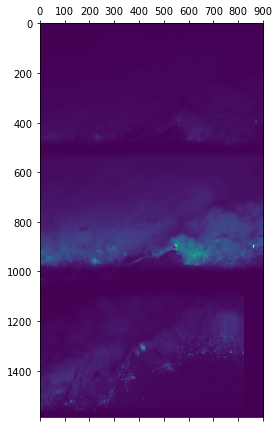

In [43]:
plt.matshow(mosaic_90)

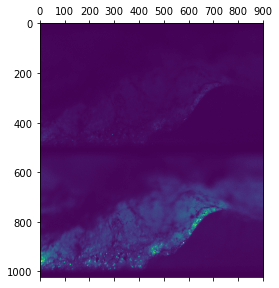

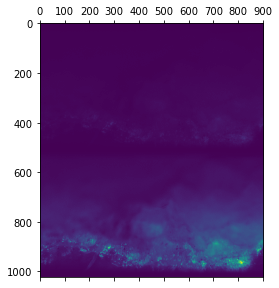

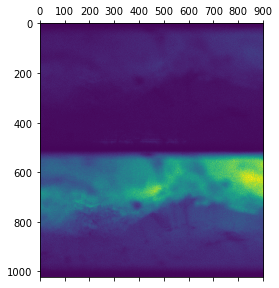

In [51]:
dapi1 = tif.imread('/home/nicholasreder/alpenglow/data/nhsaf647/DAPI_1_00100.tif')
dapi2 = tif.imread('/home/nicholasreder/alpenglow/data/nhsaf647/DAPI_2_00100.tif')
dapi3 = tif.imread('/home/nicholasreder/alpenglow/data/nhsaf647/DAPI_3_00100.tif')
plt.matshow(dapi1)
plt.matshow(dapi2)
plt.matshow(dapi3)

In [52]:
for strip in range(1, 4):
    for zlevel in range(1,513):
        fname = "NHS_%01d_%05d.tif" % (strip, zlevel) 
        af.download_s3('nhsaf647/NHS_%01d/' % strip + fname, '/home/nicholasreder/alpenglow/data/nhsaf647/' + fname)  

In [56]:
def test_image(path, first_strip, last_strip, percentile = 50):
    p = int(np.percentile(np.arange(len(globby.glob1(path,"NHS_%01d_*.tif" % first_strip))), percentile))
    image1 = tif.imread(path + 'NHS_%01d_%05d.tif' % (first_strip, p))
    image2 = tif.imread(path + 'NHS_%01d_%05d.tif' % (first_strip + 1, p))
    mosaic, shift = stitch(image1, image2) 
    for x in range (first_strip + 2, last_strip): #
        image2 = tif.imread(path + 'NHS_%01d_%05d.tif' % (x, p))
        mosaic, shift = stitch(mosaic, image2)
    return mosaic

In [57]:
mosaic_90 = test_image("/home/nicholasreder/alpenglow/data/nhsaf647/", 1, 3, 90)
plt.matshow(mosaic_90)

ValueError: could not broadcast input array from shape (593,0) into shape (593,900)

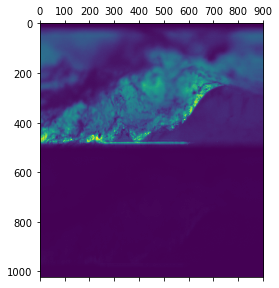

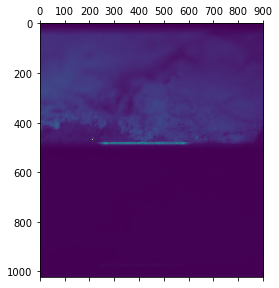

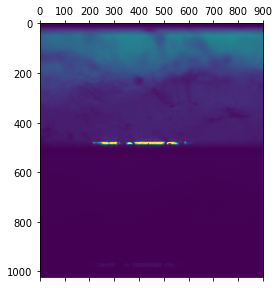

In [58]:
NHS1 = tif.imread('/home/nicholasreder/alpenglow/data/nhsaf647/NHS_1_00100.tif')
NHS2 = tif.imread('/home/nicholasreder/alpenglow/data/nhsaf647/NHS_2_00100.tif')
NHS3 = tif.imread('/home/nicholasreder/alpenglow/data/nhsaf647/NHS_3_00100.tif')
plt.matshow(NHS1)
plt.matshow(NHS2)
plt.matshow(NHS3)

## We figured out the problem: each image is split into two parts!

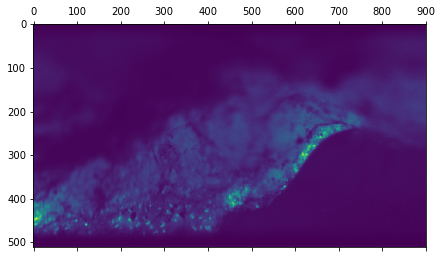

In [60]:
plt.matshow(dapi1[dapi1.shape[0]//2:,:])

In [71]:
for strip in range(1, 4):
    for zlevel in range(1,513):
        full_image = tif.imread("/home/nicholasreder/alpenglow/data/nhsaf647/DAPI_%01d_%05d.tif" % (strip, zlevel)) 
        cropped_image = full_image[full_image.shape[0]//2:,:]
        tif.imsave("/home/nicholasreder/alpenglow/data/nhsaf647/DAPI_%01d_%05d.tif" % (strip, zlevel), cropped_image)

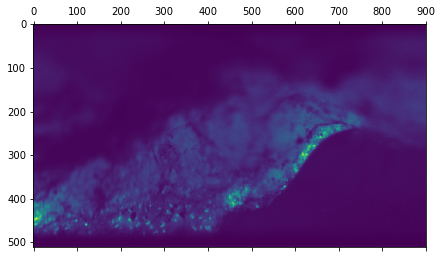

In [72]:
full_image = tif.imread("/home/nicholasreder/alpenglow/data/nhsaf647/DAPI_1_00100.tif") 
plt.matshow(full_image)

In [73]:
for strip in range(1, 4):
    for zlevel in range(1,513):
        full_image = tif.imread("/home/nicholasreder/alpenglow/data/nhsaf647/NHS_%01d_%05d.tif" % (strip, zlevel)) 
        cropped_image = full_image[full_image.shape[0]//2:,:]
        tif.imsave("/home/nicholasreder/alpenglow/data/nhsaf647/NHS_%01d_%05d.tif" % (strip, zlevel), cropped_image)

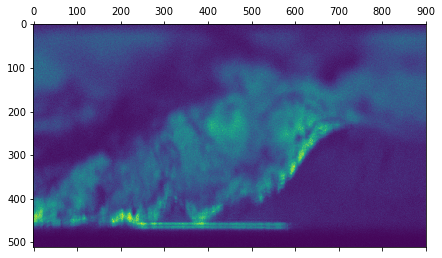

In [74]:
full_image = tif.imread("/home/nicholasreder/alpenglow/data/nhsaf647/NHS_1_00100.tif") 
plt.matshow(full_image)

#### OK, now the images are the appropriate parts of the full image

In [ ]:
def test_image(path, first_strip, last_strip, percentile = 50):
    p = int(np.percentile(np.arange(len(globby.glob1(path,"NHS_%01d_*.tif" % first_strip))), percentile))
    image1 = tif.imread(path + 'NHS_%01d_%05d.tif' % (first_strip, p))
    image2 = tif.imread(path + 'NHS_%01d_%05d.tif' % (first_strip + 1, p))
    mosaic, shift = stitch(image1, image2) 
    for x in range (first_strip + 2, last_strip): #
        image2 = tif.imread(path + 'NHS_%01d_%05d.tif' % (x, p))
        mosaic, shift = stitch(mosaic, image2)
    return mosaic

In [75]:
def test_image(path, first_strip, last_strip, percentile = 50):
    p = int(np.percentile(np.arange(len(globby.glob1(path,"NHS_%01d_*.tif" % first_strip))), percentile))
    image1 = tif.imread(path + 'NHS_%01d_%05d.tif' % (first_strip, p))
    image2 = tif.imread(path + 'NHS_%01d_%05d.tif' % (first_strip + 1, p))
    mosaic, shift = stitch(image1, image2) 
    for x in range (first_strip + 2, last_strip): #
        image2 = tif.imread(path + 'NHS_%01d_%05d.tif' % (x, p))
        mosaic, shift = stitch(mosaic, image2)
    return mosaic

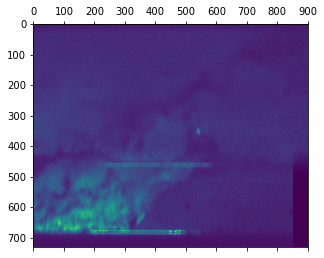

In [77]:
mosaic_50 = test_image("/home/nicholasreder/alpenglow/data/nhsaf647/", 1, 3, 50)
plt.matshow(mosaic_50)

In [78]:
def test_image(path, first_strip, last_strip, percentile = 50):
    p = int(np.percentile(np.arange(len(globby.glob1(path,"DAPI_%01d_*.tif" % first_strip))), percentile))
    image1 = tif.imread(path + 'DAPI_%01d_%05d.tif' % (first_strip, p))
    image2 = tif.imread(path + 'DAPI_%01d_%05d.tif' % (first_strip + 1, p))
    mosaic, shift = stitch(image1, image2) 
    for x in range (first_strip + 2, last_strip): #
        image2 = tif.imread(path + 'DAPI_%01d_%05d.tif' % (x, p))
        mosaic, shift = stitch(mosaic, image2)
    return mosaic

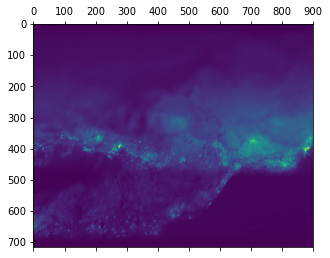

In [80]:
mosaic_20 = test_image("/home/nicholasreder/alpenglow/data/nhsaf647/", 1, 3, 20)
plt.matshow(mosaic_20)

In [5]:
def create_zstack(scan_name, strip_num, z_levels, sample_image_num = 55):
    imread = delayed(skimage.io.imread, pure=True)  # Lazy version of imread
    filenames = []
    for x in range(1, z_levels):
        fname = "%s_%01d_%05d.tif" % (scan_name, strip_num, x)
        filenames.append('/home/nicholasreder/alpenglow/data/nhsaf647/' + fname)

    lazy_values = [imread(filename) for filename in filenames]    
    sample = skimage.io.imread(filenames[sample_image_num])
    arrays = [da.from_delayed(lazy_value,           # Construct a small Dask array
                              dtype=sample.dtype,   # for every lazy value
                              shape=sample.shape)
              for lazy_value in lazy_values]

    stack = da.stack(arrays, axis=0)  

    for z in range(1,stack.shape[1]):
        filename = 'zstack_%s_%01d_%05d.tif' % (scan_name, strip_num, z) 
        tiff.imsave(filename, stack[:,z,:].compute())
    zstack = ImageCollection('zstack_%s_%01d_*.tif' % (scan_name, strip_num))
    return zstack

In [118]:
create_zstack('DAPI', 1, 512)

In [6]:
DAPI_z_1 = create_zstack('DAPI', 1, 512)
DAPI_z_2 = create_zstack('DAPI', 2, 512)
DAPI_z_3 = create_zstack('DAPI', 3, 512)
NHS_z_1 = create_zstack('NHS', 1, 512)
NHS_z_2 = create_zstack('NHS', 2, 512)
NHS_z_3 = create_zstack('NHS', 3, 512)

In [7]:
DAPI_1_2 = ast.stitch_zstack(DAPI_z_1, DAPI_z_2)

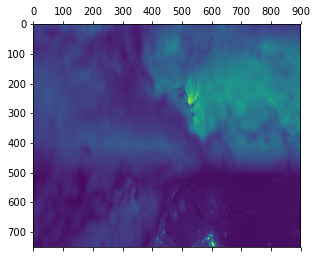

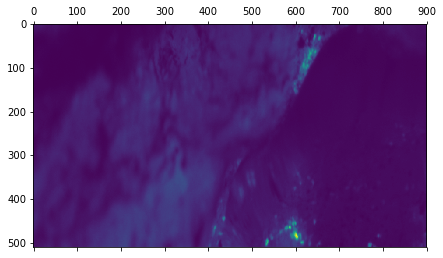

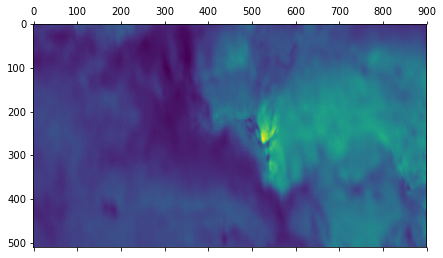

In [18]:
plt.matshow(DAPI_1_2[300])
plt.matshow(DAPI_z_1[300])
plt.matshow(DAPI_z_2[300])

#### Superslow, looks bad maybe because of raster scanning back and forth

### Finished here on 3/2, resume next time

In [74]:
files_per_strip = 1800
n_strips = 3

In [75]:
file_list = ['/nhsaf647/DAPI_%01d/DAPI_%01d_%05d.tif'%(s, s, i) for s in range(1,4) for i in range(1, 1801) ]

In [78]:
cci = cc.get_interface('alpenglowoptics', 
                       ACCESS_KEY=ak, 
                       SECRET_KEY=sk,
                       endpoint_url='https://s3.amazonaws.com',
                       verbose=False)

sample = af.s3_to_array(file_list[0], cci)




In [79]:
file_list[2000]

'/nhsaf647/DAPI_2/DAPI_2_00201.tif'

In [80]:
stack = af.read_strip_files(file_list, files_per_strip, n_strips-1, cci, sample.dtype, sample.shape)

In [81]:
stack_DAPI1_half = stack[stack.shape[0]//2:,:]

In [82]:
stack_DAPI1_half.shape

(512, 900, 1800)

In [83]:
stack2 = af.read_strip_files(file_list, files_per_strip, n_strips-2, cci, sample.dtype, sample.shape)

In [84]:
stack_DAPI2_half = stack2[stack2.shape[0]//2:,:]

In [85]:
stack_DAPI_12_half = ast.stitch_zstack(stack_DAPI1_half, stack_DAPI2_half)

ValueError: could not broadcast input array from shape (1366,1800) into shape (1436,1800)

Note to self: synthetically create a two-channel set by taking half of DAPI, half of NHS, then combining into one array. Then I can do the true workflow